*Alterations/Assumptions Made for this Project: 

I am assuming the Dataset contained customer/marketing data as of 10/30/2014 (I used enrollment date and recency from original table to come up with a reasonable estimation). Throughout the six campaigns, the offer is constant and we'll assume its a discount on a bundle of products including wine, meat, fish, sweets, and a small piece of gold jewelry. 

All of the customers included in the dataset were enrolled prior to the six marketing campaigns. Data does not account for any added customers during the six campaigns. (*Each customer was presented offer six times*) 

Amount spent on wine, meat, fish, sweets, and gold product is over the two years prior to the assumed data collection date (10/30/2014). 

In [180]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import matplotlib


plt.rcParams['figure.figsize'] = 8, 7
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "normal"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['axes.labelsize']=18
plt.rcParams['legend.fontsize']: 16
    
sns.set()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [181]:
marketing = pd.read_csv('Data/marketing_campaign.csv')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
ID                     2240 non-null int64
Year_Birth             2240 non-null int64
Education              2240 non-null object
Relationship_Status    2240 non-null object
Income                 2216 non-null float64
Kids                   2240 non-null int64
Teens                  2240 non-null int64
Enroll_Date            2240 non-null object
Recency                2240 non-null int64
Wine ($)               2240 non-null int64
Fruit ($)              2240 non-null int64
Meat ($)               2240 non-null int64
Fish ($)               2240 non-null int64
Sweets ($)             2240 non-null int64
Gold_Products ($)      2240 non-null int64
Discount_Purchases     2240 non-null int64
Web_Purchases          2240 non-null int64
Catalog_Purchases      2240 non-null int64
Store_Purchases        2240 non-null int64
Complaint              2240 non-null int64
Campaign1              2240 

Missing income information for several customers, will utilize average income for their respective education and age.

Age column will be engineered from birth dates into different group values (Ex: 20 - 29, 30 - 39...)

In [182]:
## Checking for any mistaken customer duplicate entries ###
print(max(marketing.ID.value_counts()))

1


In [183]:
### Exploring birth years of customers ###
marketing['Year_Birth'].sort_values(ascending=True)

239     1893
339     1899
192     1900
1950    1940
424     1941
        ... 
747     1995
1850    1995
696     1995
1170    1996
46      1996
Name: Year_Birth, Length: 2240, dtype: int64

The three oldest customers above have most likely passed away, I will exclude them in this study 

In [184]:
marketing = marketing.drop(index=[239, 339, 192], axis=0)

In [185]:
### Creating Age Groups (Do not know which month customers were born, we'll assume they were born after June 30th) ###
marketing['Age'] = 2014 - marketing['Year_Birth']
marketing['Age_Group'] = ''
for idx, row in marketing.iterrows():
    if 18 <= row['Age'] < 20:
        marketing.loc[idx, 'Age_Group'] = 'Late-Teens'
    elif 20 <= row['Age'] < 30:
        marketing.loc[idx, 'Age_Group'] = 'Twenties'
    elif 30 <= row['Age'] < 40:
        marketing.loc[idx, 'Age_Group'] = 'Thirties'
    elif 40 <= row['Age'] < 50:
        marketing.loc[idx, 'Age_Group'] = 'Forties'
    elif 50 <= row['Age'] < 60:
        marketing.loc[idx, 'Age_Group'] = 'Fifties'
    elif 60 <= row['Age'] < 70:
        marketing.loc[idx, 'Age_Group'] = 'Sixties'
    elif 70 <= row['Age'] < 80:
        marketing.loc[idx, 'Age_Group'] = 'Seventies'
marketing = marketing.drop(['Year_Birth'], axis=1)
marketing = marketing[['ID', 'Age', 'Age_Group', 'Education', 'Relationship_Status', 'Income', 'Kids', 'Teens', 'Enroll_Date', 'Recency', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6', 'Complaint']]

In [186]:
### Simplifying Relationship status ###
for idx, row in marketing.iterrows():
    if row['Relationship_Status'] == 'YOLO' or row['Relationship_Status'] == 'Alone' or row['Relationship_Status'] == 'Absurd':
        marketing.loc[idx, 'Relationship_Status'] = 'Single'
    elif row['Relationship_Status'] == 'Together':
        marketing.loc[idx, 'Relationship_Status'] = 'In-Relationship'
print(marketing.groupby('Relationship_Status')['Relationship_Status'].count().sort_values(ascending=False))


Relationship_Status
Married            864
In-Relationship    579
Single             486
Divorced           231
Widow               77
Name: Relationship_Status, dtype: int64


In [187]:
### Imputing missing Income values based on education & age group ###
import matplotlib.pyplot as plt

marketing = marketing.fillna(0)
for idx, row in marketing.iterrows():
    if row['Income'] == 0:
        education = row['Education']
        age_group = row['Age_Group']
        df = marketing.loc[(marketing['Education'] == education) & (marketing['Age_Group'] == age_group)]
        marketing.loc[idx, 'Income'] = np.mean(df['Income'])
print(marketing['Income'].describe())
income = sorted(list(marketing['Income'].values))
print('\n^^^Max Income of', max(income), 'is', max(income)/income[-2], 'greater than the second highest income of', income[-2])
print('\nThis one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer')
marketing = marketing.loc[~(marketing['Income'] == 666666)]

count      2237.000000
mean      52239.753759
std       25046.050354
min        1730.000000
25%       35523.000000
50%       51390.000000
75%       68281.000000
max      666666.000000
Name: Income, dtype: float64

^^^Max Income of 666666.0 is 4.105162041170711 greater than the second highest income of 162397.0

This one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer


In [188]:
### Simplifying Education ###

for idx, row in marketing.iterrows():
    if row['Education'] == '2n Cycle':
        marketing.loc[idx, 'Education'] = 'Graduation'

print(marketing.groupby('Education')['Income'].mean())

Education
Basic         20306.259259
Graduation    51489.749482
Master        52908.937257
PhD           56069.939817
Name: Income, dtype: float64


count    2236.000000
mean        0.950805
std         0.752204
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Children, dtype: float64


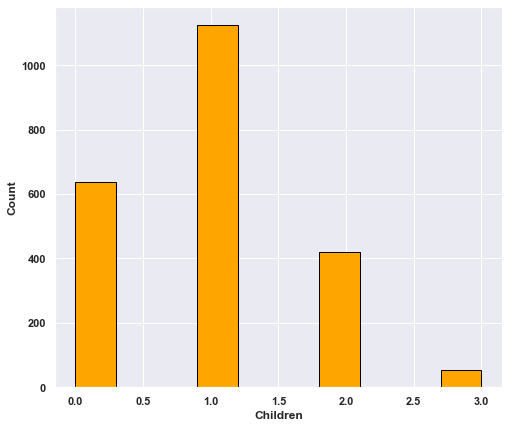

In [189]:
### Simplifying Kids and Teens columns into one 'Children' column ###

marketing['Children'] = 0
for idx, row in marketing.iterrows():
    marketing.loc[idx, 'Children'] = row['Kids'] + row['Teens']
print(marketing['Children'].describe())

plt.hist(marketing['Children'], edgecolor='black', color='orange')
plt.ylabel('Count')
plt.xlabel('Children')
plt.show()

In [190]:
### Using Enrollment Date to get idea of how long customers have been enrolled with the store ###
from datetime import datetime

date1 = datetime.strptime('2014-10-30', "%Y-%m-%d").date()
marketing['Enroll_Date'] = pd.to_datetime(marketing['Enroll_Date']).dt.date

def numOfDays(date1, date2): 
    return abs(date2-date1).days

num_of_days = []
for value in list(marketing['Enroll_Date'].values):
    days = numOfDays(date1, value)
    num_of_days.append(days)
    
marketing['Days_Enrolled'] = pd.Series([int(d) for d in num_of_days])

In [191]:
### Engineering some more features: Average Purchase Frequency and Average Spend on a Purchase ###
marketing['Total Spent ($)'] = marketing['Wine ($)'] + marketing['Fruit ($)'] + marketing['Meat ($)'] + marketing['Fish ($)'] + marketing['Sweets ($)'] + marketing['Gold_Products ($)']
marketing['Number_Purchases'] = marketing['Discount_Purchases'] + marketing['Web_Purchases'] + marketing['Catalog_Purchases'] + marketing['Store_Purchases']
marketing['Avg_Purch_Freq'] = (marketing['Days_Enrolled'] / marketing['Number_Purchases']).replace(np.inf, np.nan)
marketing['Avg_Spend ($)'] = (marketing['Total Spent ($)'] / marketing['Number_Purchases']).replace(np.inf, np.nan)

Upon examining the average spend data, the max average spend was 1,679 on one single purchase for a customer who had enrolled in 2012. The next highest average spend is 187, so I'm choosing to beleive this customer will not return and we can exclude them from analysis. Customers who have never made a single purchase were also excluded. In total this was just 5 customers that were excluded. 

In [192]:
marketing = marketing.loc[~((marketing['Avg_Spend ($)'] == 1679) | (marketing['Avg_Purch_Freq'] > 240) | (marketing['Avg_Spend ($)'].isnull()) | (marketing['Avg_Purch_Freq'].isnull()))]

Youngest Customer: 18 
Oldest Customer: 74
Age_Group
Forties       673
Thirties      551
Fifties       465
Sixties       297
Twenties      214
Seventies      16
Late-Teens      7
Name: Age_Group, dtype: int64

Most Customers are in their Forties


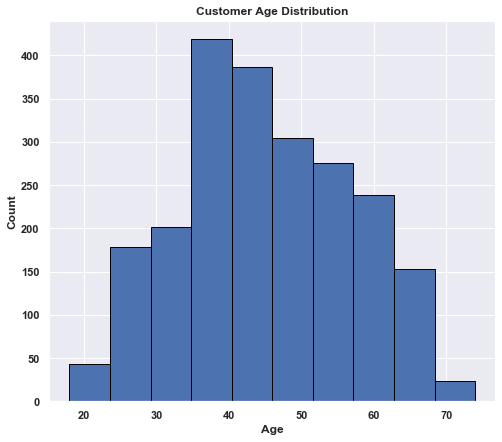

count    2223.000000
mean       45.087269
std        11.699529
min        18.000000
25%        37.000000
50%        44.000000
75%        55.000000
max        74.000000
Name: Age, dtype: float64


In [193]:
### Customer Age ###
print('Youngest Customer:', min(marketing['Age']), '\nOldest Customer:', max(marketing['Age']))
print(marketing.groupby('Age_Group')['Age_Group'].count().sort_values(ascending=False))
print('\nMost Customers are in their Forties')
plt.hist(marketing['Age'], edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Age Distribution', fontweight='bold')
plt.show()
print(marketing['Age'].describe())

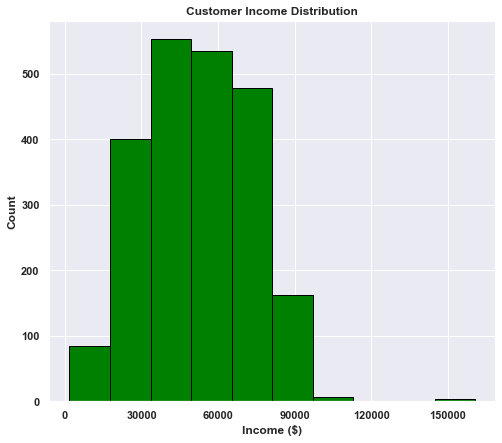

count      2223.000000
mean      51846.934963
std       20903.386647
min        1730.000000
25%       35533.500000
50%       51369.000000
75%       68145.000000
max      160803.000000
Name: Income, dtype: float64


In [194]:
### Customer Income ###
plt.hist(marketing['Income'], edgecolor='black', color='green')
plt.title('Customer Income Distribution', fontweight='bold')
plt.xlabel('Income ($)')
plt.ylabel('Count')
plt.xticks([0, 30000, 60000, 90000, 120000, 150000])
plt.show()
print(marketing['Income'].describe())

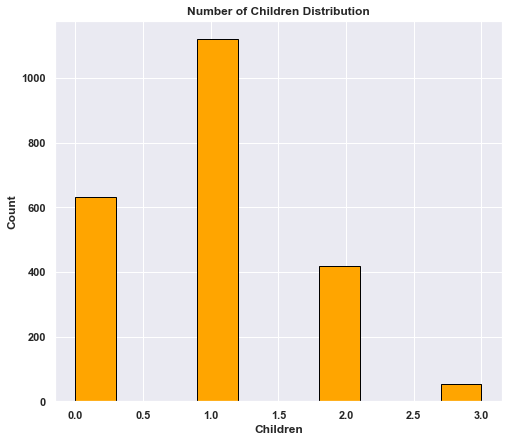

count    2223.000000
mean        0.951417
std         0.750863
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Children, dtype: float64


In [195]:
## Number of Children Distribution ###

plt.hist(marketing['Children'], edgecolor='black', color='orange')
plt.ylabel('Count')
plt.xlabel('Children')
plt.title('Number of Children Distribution', fontweight='bold')
plt.show()
print(marketing['Children'].describe())

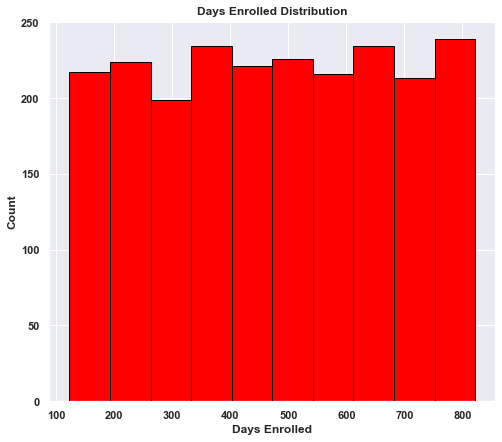

count    2223.000000
mean      476.506523
std       202.258986
min       123.000000
25%       303.500000
50%       479.000000
75%       651.500000
max       822.000000
Name: Days_Enrolled, dtype: float64 

Customer acquisition rate has been relatively steady. (very slight decline over time, but nothing overly concerning)


In [196]:
### Customer Amount of Days Enrolled ###
plt.hist(marketing['Days_Enrolled'], edgecolor='black', color='red')
plt.xlabel('Days Enrolled')
plt.ylabel('Count')
plt.title('Days Enrolled Distribution', fontweight='bold')
plt.show()
print(marketing['Days_Enrolled'].describe(), '\n\nCustomer acquisition rate has been relatively steady. (very slight decline over time, but nothing overly concerning)')

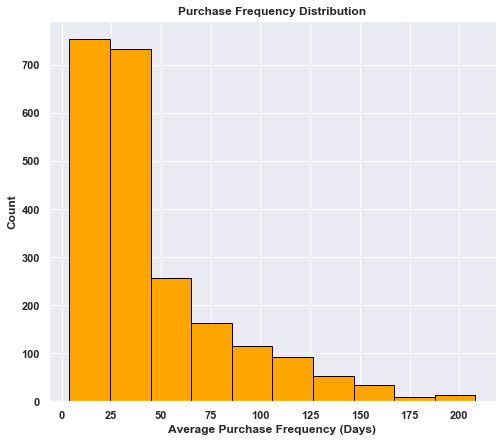

count    2223.000000
mean       45.038027
std        36.953096
min         3.968750
25%        20.209430
50%        31.823529
75%        58.000000
max       208.000000
Name: Avg_Purch_Freq, dtype: float64


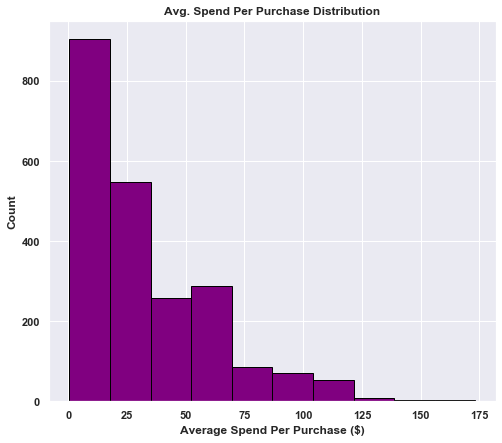

count    2223.000000
mean       32.436249
std        28.232230
min         0.533333
25%         9.707143
50%        23.352941
75%        45.029412
max       173.230769
Name: Avg_Spend ($), dtype: float64


In [197]:
### Customer Purchase Frequency ###
plt.hist(marketing['Avg_Purch_Freq'], edgecolor='black', color='orange')
plt.ylabel('Count')
plt.xlabel('Average Purchase Frequency (Days)')
plt.title('Purchase Frequency Distribution', fontweight='bold')
plt.show()
print(marketing['Avg_Purch_Freq'].describe())

### Customer Average Spend Per Purchase ###
plt.hist(marketing['Avg_Spend ($)'], edgecolor='black', color='purple')
plt.ylabel('Count')
plt.xlabel('Average Spend Per Purchase ($)')
plt.title('Avg. Spend Per Purchase Distribution', fontweight='bold')
plt.show()
print(marketing['Avg_Spend ($)'].describe())

In [198]:
### Adding Acceptance (%) for each customer after the six campaigns ###
campaigns = ['Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6']
marketing['Cust_Accept (%)'] = 0
marketing['Accept_One'] = 0
for idx, row in marketing.iterrows():
    acceptance_count = 0
    for campaign in campaigns:
        if row[campaign] == 1:
            acceptance_count += 1
    if acceptance_count > 0:
        marketing.loc[idx, 'Accept_One'] = 1
    acceptance_rate = (acceptance_count / 6) * 100
    marketing.loc[idx, 'Cust_Accept (%)'] = acceptance_rate
print(marketing['Cust_Accept (%)'].describe())
num_acc = sum(marketing['Accept_One'])
print('\nValue Counts (%)\n', marketing['Cust_Accept (%)'].value_counts())
print('\n', num_acc, 'customers accepted the offer at least once during the six campaigns')

sum_accepted = 0
total_attempts = 6 * len(marketing)
for campaign in campaigns:
    sum_accepted += sum(marketing[campaign])
overall = sum_accepted / total_attempts * 100
print('\nThe offer was accepted', sum_accepted, 'times out of', total_attempts, 'attempts for an overall acceptance percentage of', str(round(overall, 2)) + '%')

count    2223.000000
mean        7.467386
std        14.882566
min         0.000000
25%         0.000000
50%         0.000000
75%        16.666667
max        83.333333
Name: Cust_Accept (%), dtype: float64

Value Counts (%)
 0.000000     1619
16.666667     365
33.333333     142
50.000000      51
66.666667      36
83.333333      10
Name: Cust_Accept (%), dtype: int64

 604 customers accepted the offer at least once during the six campaigns

The offer was accepted 996 times out of 13338 attempts for an overall acceptance percentage of 7.47%


In [199]:
# Age Group Data #

dict_percent = collections.defaultdict(list)
for category in list(marketing['Age_Group'].unique()):
    dict_percent['Age_Group'].append(category)
    total = len(marketing.loc[marketing['Age_Group'] == category])
    accept = len(marketing.loc[(marketing['Age_Group'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Age_Group,Accept_One (%),(1),(0),Total Customers
0,Seventies,56.250000,9,7,16
1,Late-Teens,42.857143,3,4,7
2,Fifties,29.462366,137,328,465
3,Sixties,28.282828,84,213,297
4,Forties,26.597325,179,494,673
5,Twenties,25.700935,55,159,214
6,Thirties,24.863884,137,414,551


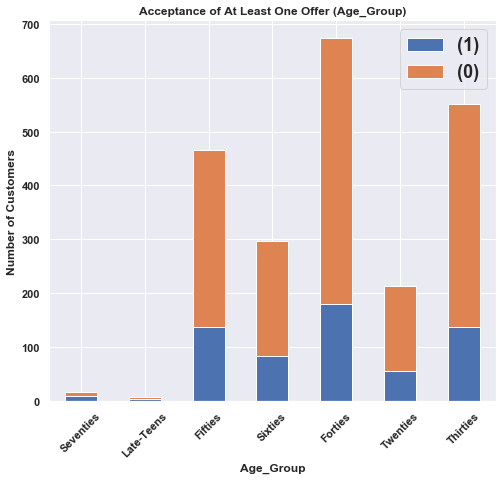

In [200]:
# Age_Group Visualization #

df_percents = df_percents[['Age_Group', '(1)', '(0)' ]]
df_percents.plot(x='Age_Group', kind='bar', stacked=True, mark_right=True)
plt.title('Acceptance of At Least One Offer (Age_Group)', fontweight='bold')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()

In [201]:
# Education Data #

dict_percent = collections.defaultdict(list)
for category in list(marketing['Education'].unique()):
    dict_percent['Education'].append(category)
    total = len(marketing.loc[marketing['Education'] == category])
    accept = len(marketing.loc[(marketing['Education'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Education,Accept_One (%),(1),(0),Total Customers
0,PhD,32.291667,155,325,480
1,Master,27.247956,100,267,367
2,Graduation,25.869894,342,980,1322
3,Basic,12.962963,7,47,54


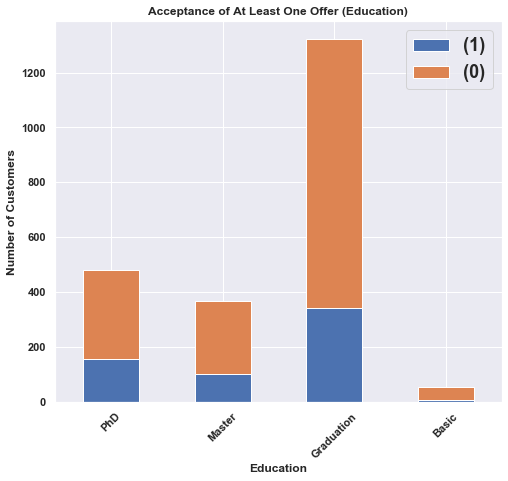

In [202]:
# Education Visualization #

df_percents = df_percents[['Education', '(1)', '(0)' ]]
df_percents.plot(x='Education', kind='bar', stacked=True, mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Education)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()

In [203]:
# Relationship Status Data #

dict_percent = collections.defaultdict(list)
for category in list(marketing['Relationship_Status'].unique()):
    dict_percent['Relationship_Status'].append(category)
    total = len(marketing.loc[marketing['Relationship_Status'] == category])
    accept = len(marketing.loc[(marketing['Relationship_Status'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Relationship_Status,Accept_One (%),(1),(0),Total Customers
0,Widow,35.064935,27,50,77
1,Single,31.198347,151,333,484
2,Divorced,29.824561,68,160,228
3,Married,25.058005,216,646,862
4,In-Relationship,24.825175,142,430,572


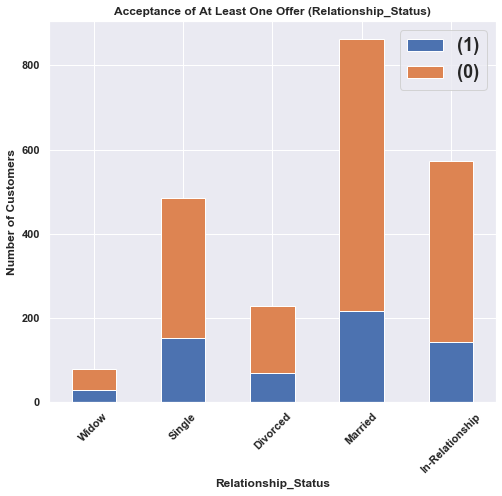

In [204]:
# Relationship_Status Visualization #

df_percents = df_percents[['Relationship_Status', '(1)','(0)']]
df_percents.plot(x='Relationship_Status', kind='bar', stacked=True, mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Relationship_Status)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()

In [205]:
# Number of Children Data #

dict_percent = collections.defaultdict(list)
for category in list(marketing['Children'].unique()):
    dict_percent['Children'].append(category)
    total = len(marketing.loc[marketing['Children'] == category])
    accept = len(marketing.loc[(marketing['Children'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Children,Accept_One (%),(1),(0),Total Customers
0,0,44.690967,282,349,631
1,1,21.052632,236,885,1121
2,2,19.093079,80,339,419
3,3,11.538462,6,46,52


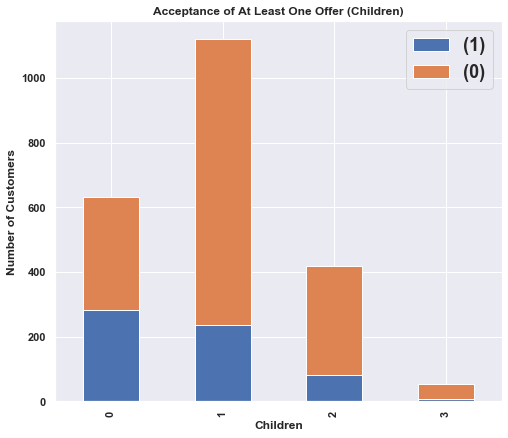

'The offer was very popular with those that do not have any children. This compliments what we saw earlier in single adults having a respectable acceptance percentage to the offer'

In [206]:
# Number of Children Visualization #

df_percents = df_percents[['Children', '(1)', '(0)' ]]
df_percents.plot(x='Children', kind='bar', stacked=True, mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Children)', fontweight='bold')
plt.xticks(rotation=90)
plt.legend(fontsize=18)
plt.show()
'The offer was very popular with those that do not have any children. This compliments what we saw earlier in single adults having a respectable acceptance percentage to the offer'


In [207]:
### Analyzing total customer spend by product ###
dict_products = collections.defaultdict(list)
total_cust_spend = sum(marketing['Wine ($)']) + sum(marketing['Fruit ($)']) + sum(marketing['Meat ($)']) + sum(marketing['Fish ($)']) + sum(marketing['Sweets ($)']) + sum(marketing['Gold_Products ($)'])
for product in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']:
    dict_products['Product'].append(product[:-4])
    prod_spend = sum(marketing[product])
    dict_products['Total Customer Spend ($)'].append(prod_spend)
    percent_spend = (prod_spend / total_cust_spend) * 100
    dict_products['Revenue %'].append(percent_spend)
df_products = pd.DataFrame(dict_products)
df_products.sort_values('Revenue %', ascending=False).reset_index(drop=True)

,Product,Total Customer Spend ($),Revenue %
0,Wine,677866,50.215793
1,Meat,371178,27.496581
2,Gold_Products,97922,7.253987
3,Fish,83792,6.207247
4,Sweets,60497,4.481571
5,Fruit,58651,4.344821


In [208]:
### Classifying Customers Based on what product they spend the most money on ###
marketing['Favorite_Product'] = ''
for idx, row in marketing.iterrows():
    cust_spend = []
    for product in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']:
        cust_spend.append(row[product])
    most_spend = max(cust_spend)
    for product_name in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)']: 
        if row[product_name] == most_spend:
            marketing.loc[idx, 'Favorite_Product'] = product_name[:-4]

# Favorite Product Data #
dict_percent = collections.defaultdict(list)
for category in list(marketing['Favorite_Product'].unique()):
    dict_percent['Favorite_Product'].append(category)
    total = len(marketing.loc[marketing['Favorite_Product'] == category])
    accept = len(marketing.loc[(marketing['Favorite_Product'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    no_accept = total - accept
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Favorite_Product,Accept_One (%),(1),(0),Total Customers
0,Wine,29.144385,436,1060,1496
1,Gold_Products,25.388601,49,144,193
2,Meat,24.888889,112,338,450
3,Sweets,23.529412,4,13,17
4,Fruit,9.090909,1,10,11
5,Fish,3.571429,2,54,56


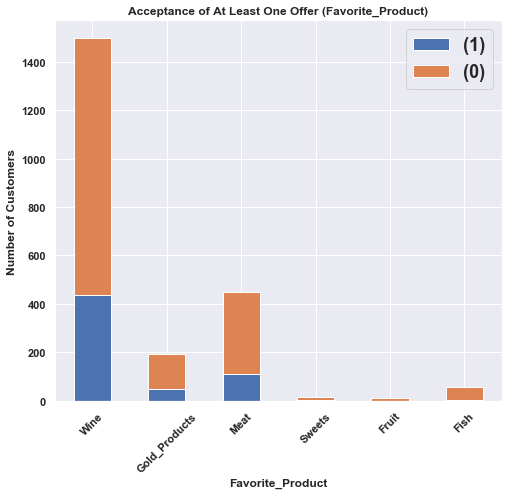

'The acceptance was very poor among customers who spend most of their money on fish products'

In [209]:
# Favorite_Product Visualization #

df_percents = df_percents[['Favorite_Product', '(1)', '(0)' ]]
df_percents.plot(x='Favorite_Product', kind='bar', stacked=True, title='Acceptance of At Least One Offer (Favorite_Product)', mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Favorite_Product)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()
'The acceptance was very poor among customers who spend most of their money on fish products'

In [210]:
### Analyzing total purchase count by purchase channel ###
dict_channels = collections.defaultdict(list)
total_num_purchases = sum(marketing['Discount_Purchases']) + sum(marketing['Web_Purchases']) + sum(marketing['Catalog_Purchases']) + sum(marketing['Store_Purchases'])
for channel in ['Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases']:
    dict_channels['Purchase Channel'].append(channel[:-10])
    num_purchases = sum(marketing[channel])
    dict_channels['Total # of Purchases'].append(num_purchases)
    percent_purchases = (num_purchases / total_num_purchases) * 100
    dict_channels['Purchase %'].append(percent_purchases)
df_products = pd.DataFrame(dict_channels)
df_products.sort_values('Purchase %', ascending=False).reset_index(drop=True)

,Purchase Channel,Total # of Purchases,Purchase %
0,Store,12922,38.953366
1,Web,9119,27.489223
2,Catalog,5944,17.918186
3,Discount,5188,15.639225


In [211]:
## Classifying Customers Based on what purchase channel they utilized most ###
marketing['Favorite_Channel'] = ''
for idx, row in marketing.iterrows():
    cust_purchase_counts = []
    for channel in ['Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases']:
        cust_purchase_counts.append(row[channel])
    most_purchases = max(cust_purchase_counts)
    # Allowing the tie breaker to go to channels that had the lowest channel % of purchases among all the customers #
    for channel_name in ['Store_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Discount_Purchases']: 
        if row[channel_name] == most_purchases:
            marketing.loc[idx, 'Favorite_Channel'] = channel_name[:-10]
    
# Favorite Purchase Channel Data #
dict_percent = collections.defaultdict(list)
for category in list(marketing['Favorite_Channel'].unique()):
    dict_percent['Favorite_Channel'].append(category)
    total = len(marketing.loc[marketing['Favorite_Channel'] == category])
    accept = len(marketing.loc[(marketing['Favorite_Channel'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=False)
df_percents.reset_index(drop=True)

,Favorite_Channel,Accept_One (%),(1),(0),Total Customers
0,Catalog,55.029586,93,76,169
1,Web,33.793103,147,288,435
2,Discount,28.832117,79,195,274
3,Store,21.189591,285,1060,1345


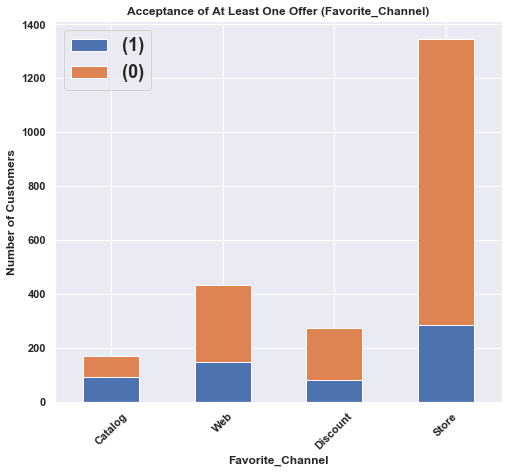

'Here we see that the offer is very succesful among those who make most of their purchases via catalog. More than half of them accepted the offer which is very encouraging.'

In [212]:
# Favorite Purchase Channel Visualization #

df_percents = df_percents[['Favorite_Channel', '(1)', '(0)' ]]
df_percents.plot(x='Favorite_Channel', kind='bar', stacked=True, mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Favorite_Channel)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()

'Here we see that the offer is very succesful among those who make most of their purchases via catalog. More than half of them accepted the offer which is very encouraging.'

In [213]:
### Analyzing Acceptance based on a how often a customer makes a purchase ###
marketing['Purchase_Frequency'] = ''
for idx, row in marketing.iterrows():
    if 0 < row['Avg_Purch_Freq'] < 14:
        marketing.loc[idx, 'Purchase_Frequency'] = '<2'
    elif 14 <= row['Avg_Purch_Freq'] < 42:
        marketing.loc[idx, 'Purchase_Frequency'] = '2-6'
    elif 42 <= row['Avg_Purch_Freq'] < 70:
        marketing.loc[idx, 'Purchase_Frequency'] = '6-10'
    else:
        marketing.loc[idx, 'Purchase_Frequency'] = '>10'

        
# Purchase Frequency Data #        
dict_percent = collections.defaultdict(list)
for category in list(marketing['Purchase_Frequency'].unique()):
    dict_percent['Purchase_Frequency'].append(category)
    total = len(marketing.loc[marketing['Purchase_Frequency'] == category])
    accept = len(marketing.loc[(marketing['Purchase_Frequency'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One %'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One %', ascending=False)
df_percents.columns = ['Avg_Purch_Freq (Weeks)', 'Accept_One (%)', '(1)', '(0)', 'Total Customers']
df_percents.reset_index(drop=True)

,Avg_Purch_Freq (Weeks),Accept_One (%),(1),(0),Total Customers
0,<2,41.554054,123,173,296
1,2-6,31.754386,362,778,1140
2,6-10,16.905444,59,290,349
3,>10,13.698630,60,378,438


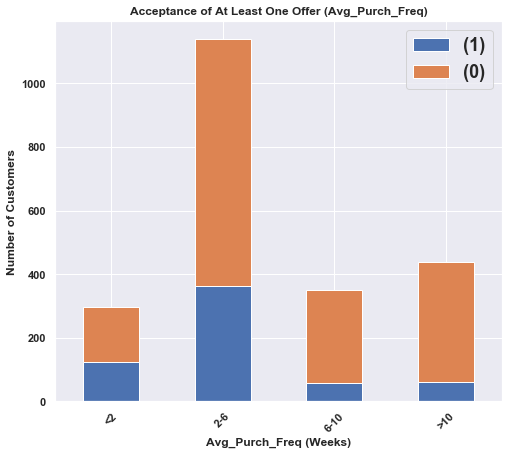


The offer is increasingly more popular with those who purchase products from the company more frequently 

 74.14% of customers average a product purchase within every six weeks


In [214]:
# Purchase Frequency Visualization #

df_percents = df_percents[['Avg_Purch_Freq (Weeks)', '(1)', '(0)']]
df_percents.plot(x='Avg_Purch_Freq (Weeks)', kind='bar', stacked=True, mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Avg_Purch_Freq)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()

print('\nThe offer is increasingly more popular with those who purchase products from the company more frequently', '\n\n', str(round((((1013 + 638) / 2227) * 100), 2)) + '% of customers average a product purchase within every six weeks')

In [215]:
### Analyzing Acceptance based on a customer's average spend per purchase ###

marketing['Avg_Spend_Purchase'] = ''
for idx, row in marketing.iterrows():
    if 0 < row['Avg_Spend ($)'] < 20:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '<20'
    elif 20 <= row['Avg_Spend ($)'] < 60:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '20-60'
    elif 60 <= row['Avg_Spend ($)'] < 120:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '60-120'
    else:
        marketing.loc[idx, 'Avg_Spend_Purchase'] = '>120'
            
dict_percent = collections.defaultdict(list)
for category in list(marketing['Avg_Spend_Purchase'].unique()):
    dict_percent['Avg_Spend ($)'].append(category)
    total = len(marketing.loc[marketing['Avg_Spend_Purchase'] == category])
    accept = len(marketing.loc[(marketing['Avg_Spend_Purchase'] == category) & (marketing['Accept_One'] == 1)])
    no_accept = total - accept
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['(1)'].append(accept)
    dict_percent['(0)'].append(no_accept)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent).sort_values('Accept_One (%)', ascending=True)
df_percents.reset_index(drop=True)

,Avg_Spend ($),Accept_One (%),(1),(0),Total Customers
0,<20,14.717742,146,846,992
1,20-60,27.169811,216,579,795
2,60-120,54.869359,231,190,421
3,>120,73.333333,11,4,15


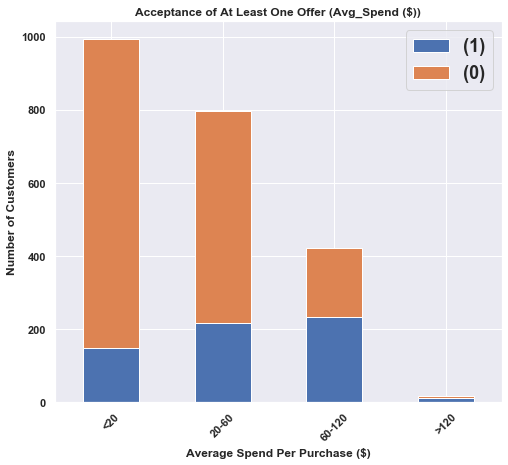

'The offer is increasingly more popular among those who spend more per purchase. These customers favor buying in bulk as their goal is to save some money. When you present an offer to further save money to these customers on their bulk purchase, its reasonable to assume they will be more likely to accept the offer'

In [216]:
# Avg_Spend Visualization #

df_percents = df_percents[['Avg_Spend ($)', '(1)', '(0)' ]]
df_percents.plot(x='Avg_Spend ($)', kind='bar', stacked=True, title='Acceptance of At Least One Offer (Avg_Spend ($))', mark_right=True)
plt.ylabel('Number of Customers')
plt.title('Acceptance of At Least One Offer (Avg_Spend ($))', fontweight='bold')
plt.xlabel('Average Spend Per Purchase ($)')
plt.xticks(rotation=45)
plt.legend(fontsize=18)
plt.show()
'The offer is increasingly more popular among those who spend more per purchase. These customers favor buying in bulk as their goal is to save some money. When you present an offer to further save money to these customers on their bulk purchase, its reasonable to assume they will be more likely to accept the offer'

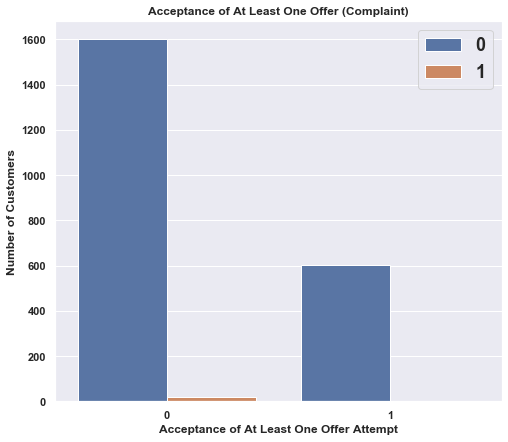

 Complaint  Accept_One (%)  Total Customers
         0        27.28098             2203
         1        15.00000               20


'We cant say that complaints is a significant factor in whether the customer will accept offer or not from the above figures. Only 20 customers filed a complaint in the last 2 years, leading to severe oversampling in those who did not complain when approaching Machine Learning modeling. Complaint is among several features I will drop below'

In [217]:
### Seeing if customer complaints affected acceptance ###

ax = sns.countplot('Accept_One', hue='Complaint', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance of At Least One Offer Attempt')
plt.title('Acceptance of At Least One Offer (Complaint)', fontweight='bold')
plt.legend(fontsize=18)
plt.show()
dict_percent = collections.defaultdict(list)

for category in list(marketing['Complaint'].unique()):
    dict_percent['Complaint'].append(category)
    total = len(marketing.loc[marketing['Complaint'] == category])
    accept = len(marketing.loc[(marketing['Complaint'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Accept_One (%)'].append(percent)
    dict_percent['Total Customers'].append(total)
df_percents = pd.DataFrame(dict_percent)
print(df_percents.to_string(index=False))
'We cant say that complaints is a significant factor in whether the customer will accept offer or not from the above figures. Only 20 customers filed a complaint in the last 2 years, leading to severe oversampling in those who did not complain when approaching Machine Learning modeling. Complaint is among several features I will drop below'

In [218]:
### Dropping unnecessary features / features used to engineer others ###
marketing = marketing.drop(['ID', 'Age_Group', 'Recency', 'Kids', 'Teens', 'Enroll_Date', 'Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6', 'Number_Purchases', 'Favorite_Product', 'Favorite_Channel', 'Purchase_Frequency', 'Avg_Spend_Purchase', 'Complaint'], axis=1)
marketing = marketing[['Age', 'Education', 'Relationship_Status', 'Income', 'Children', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)','Accept_One', 'Cust_Accept (%)']]

for idx, row in marketing.iterrows():
    if row['Cust_Accept (%)'] == 0:
            marketing.loc[idx, 'Accept_Rate'] = '(0/6)'
    elif row['Cust_Accept (%)'] == ((1/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(1/6)'
    elif row['Cust_Accept (%)'] == ((2/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(2/6)'
    elif row['Cust_Accept (%)'] == ((3/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(3/6)'
    elif row['Cust_Accept (%)'] == ((4/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(4/6)'
    elif row['Cust_Accept (%)'] == ((5/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '(5/6)'

marketing = marketing[['Age', 'Education', 'Relationship_Status', 'Income', 'Children', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)','Accept_One', 'Accept_Rate', 'Cust_Accept (%)']]

### Obtaining DF to be utilized in Machine Learning Notebook ###
marketing.to_csv('Cust_Records.csv', index=False)

In [219]:
# Accept Rate Value Counts #
marketing['Accept_Rate'].value_counts()

(0/6)    1619
(1/6)     365
(2/6)     142
(3/6)      51
(4/6)      36
(5/6)      10
Name: Accept_Rate, dtype: int64

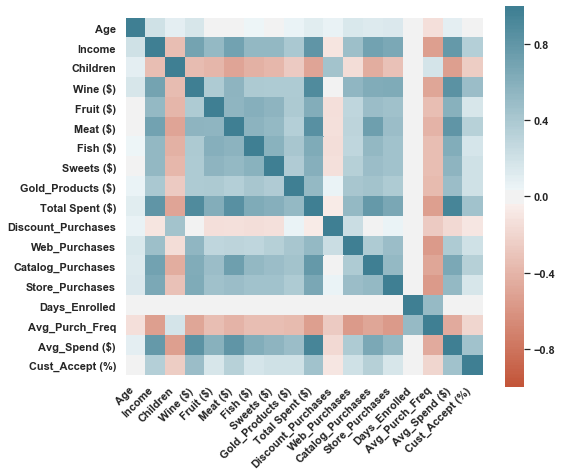

In [220]:
### Correlation Heatmap ###

numerical = marketing.drop(['Education', 'Relationship_Status', 'Accept_One'], axis=1)
corr = numerical.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

From above figure, I'd say that Income, Amount of money spend on wine products ("Wine ($)"), number of catalog purchases, and the average amount of money a customer spends per purchase are the greatest drivers of increasing a customers offer acceptance percentage. All of these features contained positive correlation with eachother. 

The number of children a customer has decreased correlation across the board for the most part. Only the number of discount purchases, age, and average purchase frequency contained positive correlation, which all make some sense. Average purchases frequency also contained negative correlation with many of the features.   